In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os

HARTREE_TO_EV = 27.211386245988

# ------------------------------
# Low-level loader
# ------------------------------
def load_doss(path):
    """
    Load a CRYSTAL .DOSS file.

    Returns
    -------
    energies : (N,) array, in Hartree (E - E_F)
    cols     : (N, M) array, DOS columns (states/Hartree/cell)
    """
    energies = []
    cols = []
    with open(path) as f:
        for line in f:
            s = line.strip()
            if not s or s.startswith("#") or s.startswith("@"):
                continue
            parts = s.split()
            vals = [float(p) for p in parts]
            energies.append(vals[0])
            cols.append(vals[1:])
    energies = np.array(energies)
    cols = np.array(cols)
    return energies, cols


# ------------------------------
# Reusable plotting function
# ------------------------------
def plot_spin_resolved_doss(
    alpha_path,
    beta_path,
    out_path=None,
    e_range=(-0.5, 0.0),
    dos_range=(-1000.0, 1000.0),
    drop_last_projection=True,
    labels_proj=None,
    colors=None,
    figsize=(4, 6),
    dpi=600,
    show_fermi=True,
    show=False,
):
    """
    Plot spin-resolved DOS (ALPHA filled, BETA dashed lines) for multiple projections.

    Parameters
    ----------
    alpha_path, beta_path : str
        Paths to *_ALPHA.DOSS and *_BETA.DOSS files.
    out_path : str or None
        If given, save figure to this path.
    e_range : (emin, emax)
        Energy window in eV for y-axis.
    dos_range : (xmin, xmax)
        DOS range for x-axis.
    drop_last_projection : bool
        If True, drop the last DOS column (e.g. total DOS or proj 5).
    labels_proj : list of str or None
        Labels for projections. If None, a default is used for 4 projections.
    colors : list of color specs or None
        Colors for projections. If None, a default list is used.
    figsize : (w, h)
        Figure size in inches.
    dpi : int
        Dots per inch for saving.
    show_fermi : bool
        Draw horizontal Fermi level at 0 eV.
    show : bool
        Call plt.show() at the end.
    """
    # --- Style (once per call, minimal) ---
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 11,
        "axes.labelsize": 11,
        "axes.linewidth": 1.0,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.minor.size": 2,
        "ytick.minor.size": 2,
        "xtick.major.width": 1.0,
        "ytick.major.width": 1.0,
    })

    # --- Load data ---
    energies_a, cols_a = load_doss(alpha_path)
    energies_b, cols_b = load_doss(beta_path)

    # sanity check
    if not np.allclose(energies_a, energies_b):
        raise ValueError("Energy grids in ALPHA and BETA files do not match.")

    # Optionally drop last projection (e.g. total or proj 5)
    if drop_last_projection:
        cols_a = cols_a[:, :-1]
        cols_b = cols_b[:, :-1]

    n_proj = cols_a.shape[1]

    # Energy to eV
    energies_ev = energies_a * HARTREE_TO_EV

    # Default labels (assuming 4 projections: Ga, O_I, O_II, O_III)
    if labels_proj is None:
        if n_proj == 4:
            labels_proj = [
                r"Ga",
                r"$\mathrm{O}_{\mathrm{I}}$",
                r"$\mathrm{O}_{\mathrm{II}}$",
                r"$\mathrm{O}_{\mathrm{III}}$",
            ]
        else:
            labels_proj = [f"Proj {i+1}" for i in range(n_proj)]

    # Default colors
    if colors is None:
        base_colors = [
            "blue",      # Ga
            "#d62728",
            "#16d5d5",
            "#7a8831",
        ]
        if n_proj <= len(base_colors):
            colors = base_colors[:n_proj]
        else:
            # extend if ever needed
            colors = base_colors + ["C{}".format(i) for i in range(len(base_colors), n_proj)]

    # ------------------------------
    # Plot
    # ------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    for i in range(n_proj):
        ya = cols_a[:, i]   # DOS alpha
        yb = cols_b[:, i]   # DOS beta

        # ALPHA: fill (horizontal axis is DOS, vertical is Energy)
        ax.fill_betweenx(
            energies_ev,
            0.0,
            ya,
            alpha=0.5,
            color=colors[i],
            linewidth=0.0,
        )

        # BETA: dashed line
        ax.plot(
            yb,
            energies_ev,
            color=colors[i],
            linewidth=1.0,
            linestyle="--",
        )

    # Axis limits: DOS (x), Energy (y)
    ax.set_xlim(dos_range[0], dos_range[1])
    ax.set_ylim(e_range[0], e_range[1])

    # Remove titles and tick labels, keep ticks
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(top=True, right=True, labelbottom=False, labelleft=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Fermi level
    if show_fermi:
        ax.axhline(0.0, linestyle="--", linewidth=1.0, color="black")

    ax.grid(False)

    # Optional legend (same style as before, but off by default)
    # proj_handles = [
    #     Patch(facecolor=colors[i], edgecolor="none", alpha=0.6)
    #     for i in range(n_proj)
    # ]
    # proj_legend = ax.legend(
    #     proj_handles,
    #     labels_proj,
    #     frameon=True,
    #     loc="upper right",
    #     borderaxespad=0.8,
    # )
    # frame1 = proj_legend.get_frame()
    # frame1.set_edgecolor("black")
    # frame1.set_linewidth(0.8)
    # ax.add_artist(proj_legend)

    fig.tight_layout()

    # Save if requested
    if out_path is not None:
        fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
        print("Saved to:", out_path)

    if show:
        plt.show()

    return fig, ax


# ------------------------------
# Example usage
# ------------------------------
# if __name__ == "__main__":

#     plot_spin_resolved_doss(
#         "GaO_PRISTINE_18HF_DOS_dat.DOSS",
#         "GaO_PRISTINE_18HF_DOS_dat.DOSS",
#         out_path="DOS_PRISTINE_ZOOM.png",
#         e_range=(-0.5, 0.0),
#         dos_range=(-1000.0, 1000.0),
#         drop_last_projection=True,  # drop proj 5
#         show=False,
#     )
#     plot_spin_resolved_doss(
#         "GaO_TETRA_18HF_DOS_dat_ALPHA.DOSS",
#         "GaO_TETRA_18HF_DOS_dat_BETA.DOSS",
#         out_path="DOS_TETRA_ZOOM.png",
#         e_range=(-0.5, 0.0),
#         dos_range=(-1000.0, 1000.0),
#         drop_last_projection=True,  # drop proj 5
#         show=False,
#     )
#     plot_spin_resolved_doss(
#         "GaO_TETRA_18HF_DOS_dat_ALPHA_positive.DOSS",
#         "GaO_TETRA_18HF_DOS_dat_BETA_negative.DOSS",
#         out_path="DOS_TETRA_ZOOM.png",
#         e_range=(-0.5, 0.0),
#         dos_range=(-1000.0, 1000.0),
#         drop_last_projection=True,  # drop proj 5
#         show=False,
#     )
#     plot_spin_resolved_doss(
#         "GaO_OCTA_18HF_DOS_dat_ALPHA.DOSS",
#         "GaO_OCTA_18HF_DOS_dat_BETA.DOSS",
#         out_path="DOS_OCTA_ZOOM.png",
#         e_range=(-0.5, 0.0),
#         dos_range=(-1000.0, 1000.0),
#         drop_last_projection=True,  # drop proj 5
#         show=False,
#     )
#     plot_spin_resolved_doss(
#         "GaO_OCTA_18HF_DOS_dat_ALPHA_positive.DOSS",
#         "GaO_OCTA_18HF_DOS_dat_BETA_negative.DOSS",
#         out_path="DOS_OCTA_ZOOM.png",
#         e_range=(-0.5, 0.0),
#         dos_range=(-1000.0, 1000.0),
#         drop_last_projection=True,  # drop proj 5
#         show=False,
#     )


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# =========================================
# User-tunable layout parameters
# =========================================
FIG_SIZE = (8, 6)
WIDTH_RATIOS = (4, 4)
DOS_BETA_LINEWIDTH = 0.5

# Energy and DOS limits
E_MIN, E_MAX = -1.0, 5.0

# =========================================
# Global style
# =========================================
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.labelsize": 11,
    "axes.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
})

HARTREE_TO_EV = 27.211386245988

# =========================================
# Helpers
# =========================================
def process_band_data(file_path):
    with open(file_path, "r") as f:
        content = f.readlines()

    lines = [
        line for line in content
        if line.strip() and not line.startswith(("#", "@"))
    ]
    data = []
    for line in lines:
        try:
            data.append(list(map(float, line.split())))
        except ValueError:
            continue

    arr = np.array(data)
    if arr.size == 0:
        return np.array([]), np.array([])

    k = arr[:, 0]
    E = arr[:, 1:] * HARTREE_TO_EV
    return k, E


def get_hs_xcoords(file_path):
    coords_map = {}

    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("@ XAXIS TICK") and "," in line and "SPEC" not in line:
                try:
                    parts = line.split(",")
                    idx = int(parts[0].replace("@ XAXIS TICK", "").strip())
                    val = float(parts[1].strip())
                    coords_map[idx] = val
                except ValueError:
                    continue

    return [coords_map[i] for i in sorted(coords_map.keys())]


def load_doss(path):
    """
    Load CRYSTAL .DOSS file and also parse NSPIN from the header.
    Returns:
        energies (Hartree), cols (N x NPROJ), nspin (int or None)
    """
    energies, cols = [], []
    first_header = None

    with open(path, "r") as f:
        for line in f:
            s = line.strip()
            # grab header with NEPTS/NPROJ/NSPIN
            if s.startswith("#") and "NEPTS" in s and "NPROJ" in s and "NSPIN" in s:
                first_header = s
            if not s or s.startswith("#") or s.startswith("@"):
                continue
            vals = list(map(float, s.split()))
            energies.append(vals[0])
            cols.append(vals[1:])

    energies = np.array(energies)
    cols = np.array(cols)

    nspin = None
    if first_header is not None:
        tokens = first_header.replace("#", "").split()
        try:
            nspin = int(tokens[tokens.index("NSPIN") + 1])
        except Exception:
            nspin = None

    return energies, cols, nspin


# =========================================
# Main plot function
# =========================================
def plot_octa_band_and_dos(
    alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/OCTA/ALPHA.BAND",
    beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/OCTA/BETA.BAND",
    alpha_dos_file="GaO_OCTA_18HF_DOS_dat_ALPHA.DOSS",
    beta_dos_file="GaO_OCTA_18HF_DOS_dat_BETA.DOSS",
    output_path="OCTA_band_DOS_fixed_limits.png",
    band_legend=True,
    DOS_X_MIN=-1000,
    DOS_X_MAX=1000,
):
    # ---------- Bands ----------
    k_a, E_a = process_band_data(alpha_band_file)
    k_b, E_b = process_band_data(beta_band_file)

    if E_a.size > 0:
        E_a = E_a - 0.0
    if E_b.size > 0:
        E_b = E_b - 0.0

    # ---------- DOS ----------
    # Load alpha DOS and nspin
    energies_a, cols_a, nspin_a = load_doss(alpha_dos_file)

    # SPECIAL CASE: pristine system (NSPIN=1) -> only total DOS.
    # Here alpha_dos_file == beta_dos_file in your first call.
    if alpha_dos_file == beta_dos_file and nspin_a == 1:
        # Interpret file as total DOS and split equally into alpha/beta channels
        cols_a = cols_a / 2.0
        cols_b = cols_a.copy()
        energies_b = energies_a
    else:
        # Normal spin-polarized case (NSPIN=2, separate alpha/beta files)
        energies_b, cols_b, nspin_b = load_doss(beta_dos_file)

    energies_ev = energies_a * HARTREE_TO_EV

    if cols_a.shape[1] > 4:
        cols_a = cols_a[:, :4]
        cols_b = cols_b[:, :4]

    n_proj = cols_a.shape[1]

    labels_proj = [
        r"Ga",
        r"$\mathrm{O}_{\mathrm{II}}$",   # label for the RED curve (proj 1)
        r"$\mathrm{O}_{\mathrm{I}}$",    # label for the GREY curve (proj 2)
        r"$\mathrm{O}_{\mathrm{III}}$",  # label for BLACK curve (proj 3)
    ][:n_proj]

    colors = [
        "royalblue",      # Ga
        "#d62728",   # O_II
        "#16d5d5",   # O_I
        "#7a8831",   # O_III
    ][:n_proj]

    # ========== Figure ==========
    fig, (ax_band, ax_dos) = plt.subplots(
        1, 2,
        figsize=FIG_SIZE,
        sharey=True,
        gridspec_kw={"width_ratios": WIDTH_RATIOS},
    )

    # Turn on minor ticks and keep only the tick marks (no labels)
    for ax in (ax_band, ax_dos):
        ax.minorticks_on()
        ax.tick_params(
            axis="both",
            which="both",
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False,
        )

    # ===== Bands =====
    for ib in range(E_a.shape[1]):
        ax_band.plot(k_a, E_a[:, ib], "-", color="red", lw=0.9)
    for ib in range(E_b.shape[1]):
        ax_band.plot(k_b, E_b[:, ib], "--", color="blue", lw=0.8)

    hs_x = get_hs_xcoords(alpha_band_file)
    ax_band.set_xlim(0, hs_x[-1] if hs_x else k_a[-1])
    ax_band.set_ylim(E_MIN, E_MAX)

    for x in hs_x:
        ax_band.axvline(x, lw=0.6, alpha=0.35, color="k")

    ax_band.axhline(0, lw=0.6, ls="--", color="k")

    # Spin legend
    handles_spin = [
        Line2D([0], [0], color="red", lw=0.9, ls="-", label=r"Spin-up ($\alpha$) channel"),
        Line2D([0], [0], color="blue", lw=0.8, ls="--", label=r"Spin-down ($\beta$) channel"),
    ]
    if band_legend:
        ax_band.legend(
            handles=handles_spin,
            labels=[h.get_label() for h in handles_spin],
            loc="upper right",
            frameon=True,
            framealpha=0.95,
            fontsize=14,
        )

    # ===== DOS =====
    ax_dos.set_xlim(DOS_X_MIN, DOS_X_MAX)
    ax_dos.set_ylim(E_MIN, E_MAX)

    for i in range(n_proj):
        ya = cols_a[:, i]
        yb = cols_b[:, i]

        ax_dos.fill_betweenx(energies_ev, 0, ya, color=colors[i], alpha=0.4)
        ax_dos.plot(yb, energies_ev, color=colors[i], lw=DOS_BETA_LINEWIDTH, ls="--")

    ax_dos.axhline(0, lw=1.0, color="black")

    fig.tight_layout()
    fig.savefig(output_path, dpi=900, bbox_inches="tight")
    print("Saved:", output_path)


# --- Calls ---
# plot_octa_band_and_dos(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/PRISTINE/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/PRISTINE/BETA.BAND",
#     alpha_dos_file="GaO_PRISTINE_18HF_DOS_dat.DOSS",    # total DOS, NSPIN=1
#     beta_dos_file="GaO_PRISTINE_18HF_DOS_dat.DOSS",     # same file -> split into α/β
#     output_path="GaO_PRISTINE_BANDS.png",
#     band_legend=False,
#     DOS_X_MIN=-1000,
#     DOS_X_MAX=1000,
# )
# plot_octa_band_and_dos(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/TETRA/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/TETRA/BETA.BAND",
#     alpha_dos_file="GaO_TETRA_18HF_DOS_dat_ALPHA.DOSS",
#     beta_dos_file="GaO_TETRA_18HF_DOS_dat_BETA.DOSS",
#     output_path="GaO_TETRA_BANDS.png",
#     band_legend=False,
#     DOS_X_MIN=-1000,
#     DOS_X_MAX=1000,
# )
# plot_octa_band_and_dos(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/TETRA/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/TETRA/BETA.BAND",
#     alpha_dos_file="GaO_TETRA_18HF_DOS_dat_ALPHA_positive.DOSS",
#     beta_dos_file="GaO_TETRA_18HF_DOS_dat_BETA_negative.DOSS",
#     output_path="GaO_TETRA_BANDS.png",
#     band_legend=False,
#     DOS_X_MIN=-1000,
#     DOS_X_MAX=1000,
# )
# plot_octa_band_and_dos(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/OCTA/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/OCTA/BETA.BAND",
#     alpha_dos_file="GaO_OCTA_18HF_DOS_dat_ALPHA.DOSS",
#     beta_dos_file="GaO_OCTA_18HF_DOS_dat_BETA.DOSS",
#     output_path="GaO_OCTA_BANDS.png",
#     band_legend=True,
#     DOS_X_MIN=-1000,
#     DOS_X_MAX=1000,
# )
# plot_octa_band_and_dos(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/OCTA/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/OCTA/BETA.BAND",
#     alpha_dos_file="GaO_OCTA_18HF_DOS_dat_ALPHA_positive.DOSS",
#     beta_dos_file="GaO_OCTA_18HF_DOS_dat_BETA_negative.DOSS",
#     output_path="GaO_OCTA_BANDS.png",
#     band_legend=True,
#     DOS_X_MIN=-1000,
#     DOS_X_MAX=1000,
# )


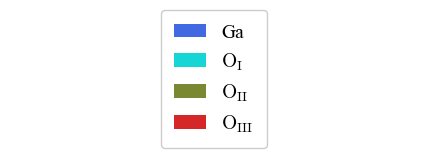

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Colors and labels ---
base_colors = [
    "royalblue",
    "#16d5d5",
    "#7a8831",
    "#d62728",
]

labels = [
    r"Ga",
    r"$\mathrm{O}_\mathrm{I}$",
    r"$\mathrm{O}_\mathrm{II}$",
    r"$\mathrm{O}_\mathrm{III}$",
]

# --- Global style: LaTeX-like Times font ---
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 14,
    "mathtext.fontset": "cm",   # Computer Modern for math
})

# --- Legend handles: colored boxes (no borders needed here) ---
handles = [Patch(facecolor=c) for c in base_colors]

# Dummy figure just to show the legend box
fig, ax = plt.subplots(figsize=(4.5, 1.5))
ax.axis("off")

leg = ax.legend(
    handles,
    labels,
    loc="center",
    ncol=1,               # change to len(labels) for a single row
    frameon=True,         # draw the box
    fancybox=True,        # rounded corners like your example
    framealpha=1.0,       # opaque box
    borderpad=0.7,
    handlelength=1.6,
    handletextpad=0.8,
)

# Set black border for the legend box
frame = leg.get_frame()
frame.set_linewidth(1.0)
frame.set_facecolor("white")

plt.tight_layout()
# fig.savefig("labels.png", dpi=900, bbox_inches="tight")
# plt.show()



In [4]:
def plot_bands_only(
    alpha_band_file,
    beta_band_file,
    output_path="bands_only.png",
    band_legend=True,
    e_min=-1.0,
    e_max=5.0,
    energy_shift=0.0,
):
    """
    Plot only the spin-polarized bands (alpha/beta) from CRYSTAL .BAND files.
    All axis labels and tick numbers are removed, but tick marks are kept.
    """
    # ---------- Load band data ----------
    k_a, E_a = process_band_data(alpha_band_file)
    k_b, E_b = process_band_data(beta_band_file)

    if E_a.size == 0 and E_b.size == 0:
        raise ValueError("No band data found in the provided .BAND files.")

    # Shift energies if requested
    if E_a.size > 0:
        E_a = E_a - energy_shift
    if E_b.size > 0:
        E_b = E_b - energy_shift

    figsize = (6, 5)
    # ---------- Figure / axis ----------
    fig, ax_band = plt.subplots(figsize=figsize)
    
    # Keep ticks (major + minor) but remove all labels
    ax_band.minorticks_on()
    ax_band.tick_params(
        axis="both",
        which="both",
        labelbottom=False,
        labelleft=False,
        labelright=False,
        labeltop=False,
    )

    # ---------- Plot bands ----------
    if E_a.size > 0:
        for ib in range(E_a.shape[1]):
            ax_band.plot(k_a, E_a[:, ib], "-", color="red", lw=0.9)
    if E_b.size > 0:
        for ib in range(E_b.shape[1]):
            ax_band.plot(k_b, E_b[:, ib], "--", color="blue", lw=0.8)

    # ---------- k-path / high-symmetry points ----------
    hs_x = get_hs_xcoords(alpha_band_file)

    if hs_x:
        ax_band.set_xlim(0, hs_x[-1])
        for x in hs_x:
            ax_band.axvline(x, lw=0.6, alpha=0.35, color="k")
    else:
        if E_a.size > 0:
            ax_band.set_xlim(k_a.min(), k_a.max())
        else:
            ax_band.set_xlim(k_b.min(), k_b.max())

    # ---------- Energy window and zero ----------
    ax_band.set_ylim(e_min, e_max)
    # ax_band.axhline(0.0, lw=0.6, ls="--", color="k")

    # ---------- Spin legend ----------
    if band_legend:
        handles_spin = [
            Line2D([0], [0], color="red", lw=0.9, ls="-",
                   label="Spin up channel"),
            Line2D([0], [0], color="blue", lw=0.8, ls="--",
                   label="Spin down channel"),
        ]
        ax_band.legend(
            handles=handles_spin,
            labels=[h.get_label() for h in handles_spin],
            loc="upper right",
            frameon=True,
            framealpha=0.95,
            fontsize=18,
        )

    fig.tight_layout()
    fig.savefig(output_path, dpi=900, bbox_inches="tight")
    print("Saved bands-only figure:", output_path)

# plot_bands_only(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/PRISTINE/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/PRISTINE/BETA.BAND",
#     output_path="GaO_PRISTINE_BANDS.png",
#     band_legend=False,
#     e_min=-1.0,
#     e_max=5.0,
#     energy_shift=0.0,
# )
# plot_bands_only(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/O1/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/O1/BETA.BAND",
#     output_path="O1.png",
#     band_legend=False,
#     e_min=-5.0,
#     e_max=4.0,
#     energy_shift=0.0,
# )
# plot_bands_only(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/O2/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/O2/BETA.BAND",
#     output_path="O2.png",
#     band_legend=False,
#     e_min=-5.0,
#     e_max=4.0,
#     energy_shift=0.0,
# )
# plot_bands_only(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/O3/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/O3/BETA.BAND",
#     output_path="O3.png",
#     band_legend=True,
#     e_min=20.0,
#     e_max=29.0,
#     energy_shift=0.0,
# )
# plot_bands_only(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/TETRA_1x2x2/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/TETRA_1x2x2/BETA.BAND",
#     output_path="TETRA_1x2x2.png",
#     band_legend=False,
#     e_min=-2.0,
#     e_max=5.0,
#     energy_shift=0.0,
# )
# plot_bands_only(
#     alpha_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/OCTA_1x2x2/ALPHA.BAND",
#     beta_band_file="/Users/felipe/FelipePhysicsPhD/Ga2O3Paper/FormalPaper/BandsFigures/18_HF/OCTA_1x2x2/BETA.BAND",
#     output_path="OCTA_1x2x2.png",
#     band_legend=True,
#     e_min=-2.0,
#     e_max=5.0,
#     energy_shift=0.0,
# )